## Importing Libraries

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.metrics import accuracy_score
import warnings
from torchvision import models, transforms
from tqdm import tqdm
import matplotlib.pyplot as plt


## Custom PyTorch Dataset

In [2]:

class CustomDataset(Dataset):
    def __init__(self, data, targets=None):
        self.data = data
        self.targets = targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        if self.targets is not None:
            return self.data[index], self.targets[index]
        return self.data[index]


## Feature Extraction Using ResNet50 (pretrained)

In [3]:

class FeatureExtractor:
    def __init__(self):
        resnet = models.resnet50(pretrained=True)
        self.model = nn.Sequential(*list(resnet.children())[:-1])
        for param in resnet.parameters():
            param.requires_grad = False
        for param in resnet.layer4.parameters():
            param.requires_grad = True
        self.model.eval()

    def extract_features(self, images):
        images = images.permute(0, 3, 1, 2)
        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        images = normalize(images)
        with torch.no_grad():
            return self.model(images).squeeze()


## Classification Model

In [4]:

class Classifier(nn.Module):
    def __init__(self, input_size, output_size):
        super(Classifier, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Linear(256, output_size)
        )

    def forward(self, x):
        return self.network(x)


## Label Smoothing Loss Function

In [5]:
class LabelSmoothing(nn.Module):
    def __init__(self, smoothing=0.1):
        super(LabelSmoothing, self).__init__()
        self.smoothing = smoothing

    def forward(self, predictions, targets):
        confidence = 1.0 - self.smoothing
        smooth = self.smoothing / predictions.size(1)
        one_hot = torch.zeros_like(predictions).scatter(1, targets.unsqueeze(1), 1)
        log_probs = predictions.log_softmax(dim=-1)
        return -(confidence * one_hot + smooth).mul(log_probs).sum(dim=1).mean()


## Function to Evaluate Model

In [6]:

def evaluate_model(model, loader, device):
    model.eval()
    all_predictions, all_targets = [], []
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            predictions = torch.argmax(outputs, dim=1)
            all_predictions.extend(predictions.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    return accuracy_score(all_targets, all_predictions)


## Data Loading Function

In [7]:

def load_dataset(filepath):
    data = torch.load(filepath)
    images = data.get('data')
    if images is None:
        raise ValueError(f"No 'data' key found in {filepath}")
    
    labels = data.get('targets', None)
    images = torch.tensor(images / 255.0, dtype=torch.float32).contiguous()
    labels = torch.tensor(labels, dtype=torch.long) if labels is not None else None
    return images, labels


## Main model Training 

Training Model 20, Epoch 5: 100%|██████████████████████████████████████████| 40/40 [00:00<00:00, 53.28it/s, loss=0.669]


Final Accuracy Matrix:
[[0.6416 0.642  0.6244 0.6396 0.6464 0.6384 0.6256 0.6168 0.6292 0.634
  0.5508 0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.6424 0.6424 0.6244 0.6392 0.6464 0.638  0.6256 0.6184 0.6296 0.6336
  0.5508 0.414  0.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.6424 0.6428 0.6248 0.6392 0.6464 0.638  0.6256 0.6184 0.63   0.6336
  0.5508 0.414  0.5264 0.     0.     0.     0.     0.     0.     0.    ]
 [0.6424 0.6428 0.6248 0.6392 0.6464 0.638  0.6256 0.6184 0.63   0.6336
  0.5508 0.414  0.5264 0.5232 0.     0.     0.     0.     0.     0.    ]
 [0.6424 0.6428 0.6248 0.6392 0.6464 0.638  0.6256 0.6184 0.63   0.6336
  0.5508 0.414  0.5264 0.5232 0.6272 0.     0.     0.     0.     0.    ]
 [0.6424 0.6428 0.6248 0.6392 0.6464 0.638  0.6256 0.6184 0.63   0.6336
  0.5508 0.414  0.5264 0.5232 0.6272 0.5176 0.     0.     0.     0.    ]
 [0.6424 0.6428 0.6248 0.6392 0.6464 0.638  0.6256 0.6184 0.63   0.6336
  0.5508 0.414  0.5264 0.5232 0.6272

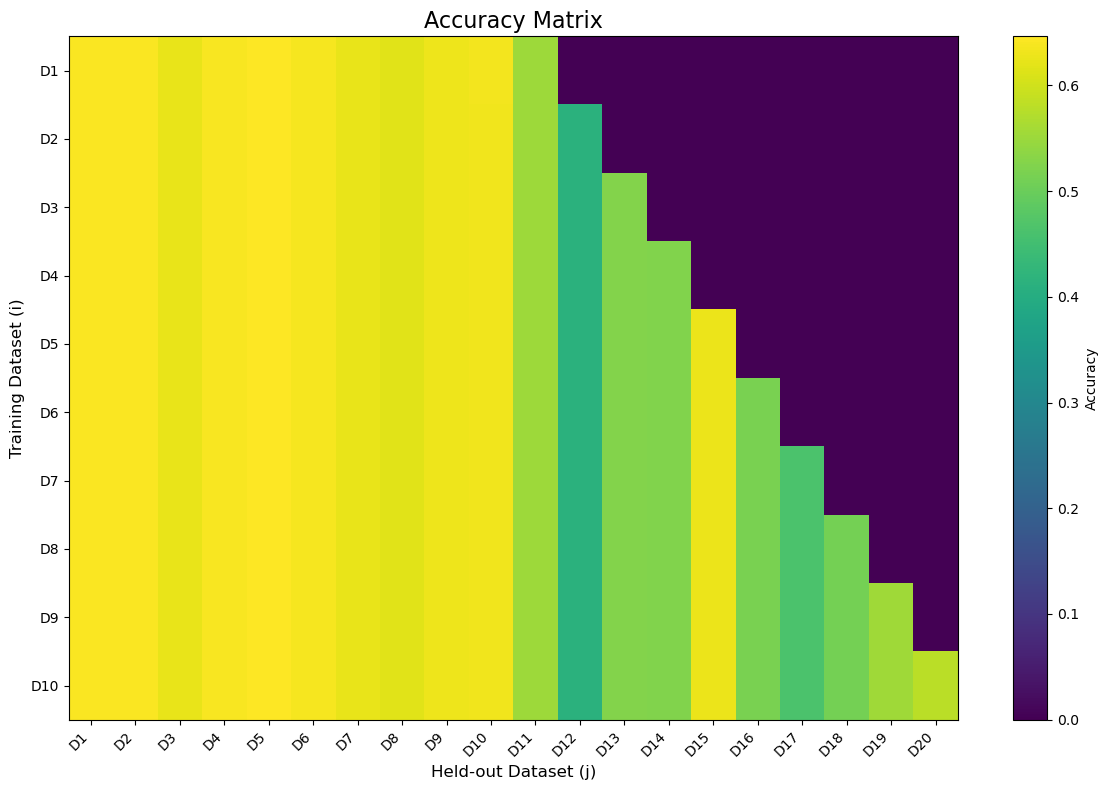

In [8]:

def train_model():
    warnings.filterwarnings("ignore")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    num_classes, batch_size, feature_size = 10, 64, 2048
    num_epochs, lr = 20, 0.001

    train_paths = [f"dataset/dataset/part_one_dataset/train_data/{i}_train_data.tar.pth" for i in range(1, 11)]
    heldout_paths_one = [f"dataset/dataset/part_one_dataset/eval_data/{i}_eval_data.tar.pth" for i in range(1, 11)]
    heldout_paths_two = [f"dataset/dataset/part_two_dataset/eval_data/{i}_eval_data.tar.pth" for i in range(1, 11)]

    model = Classifier(input_size=feature_size, output_size=num_classes).to(device)
    pretrained_state_dict = torch.load("pretrained_model.pth")  # Load the pretrained state_dict
    new_state_dict = {key.replace("fc", "network"): value for key, value in pretrained_state_dict.items()}
    model.load_state_dict(new_state_dict)  # Load the modified state_dict
    model.eval()


    feature_extractor = FeatureExtractor()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
    loss_fn = LabelSmoothing(smoothing=0.1)

    accuracy_matrix = np.zeros((10, 20))

    for i, train_path in enumerate(train_paths):
        train_images, train_labels = load_dataset(train_path)
        train_features = feature_extractor.extract_features(train_images).to(device)
        
        if train_labels is None:
            with torch.no_grad():
                train_labels = torch.argmax(model(train_features), dim=1)
        
        train_loader = DataLoader(CustomDataset(train_features, train_labels), batch_size=batch_size, shuffle=True)

        for epoch in range(num_epochs if i == 0 else 5):
            model.train()
            pbar = tqdm(train_loader, desc=f"Training Model {i+11}, Epoch {epoch+1}")
            for inputs, targets in pbar:
                inputs, targets = inputs.to(device), targets.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = loss_fn(outputs, targets)
                loss.backward()
                optimizer.step()
                pbar.set_postfix(loss=loss.item())
            scheduler.step()

        for j, eval_path in enumerate(heldout_paths_one + heldout_paths_two[:i+1]):
            eval_images, eval_labels = load_dataset(eval_path)
            eval_features = feature_extractor.extract_features(eval_images).to(device)
            eval_loader = DataLoader(CustomDataset(eval_features, eval_labels), batch_size=batch_size)
            accuracy = evaluate_model(model, eval_loader, device)
            accuracy_matrix[i, j] = accuracy

    print("Final Accuracy Matrix:")
    print(accuracy_matrix)
    torch.save(model.state_dict(), "overall_trained_model.pth")
    print("Model saved as overall_trained_model.pth")


    plt.figure(figsize=(12, 8))
    plt.imshow(accuracy_matrix, cmap="viridis", aspect="auto", interpolation="nearest")
    plt.colorbar(label="Accuracy")
    plt.title("Accuracy Matrix", fontsize=16)
    plt.xlabel("Held-out Dataset (j)", fontsize=12)
    plt.ylabel("Training Dataset (i)", fontsize=12)
    plt.xticks(np.arange(20), [f"D{i + 1}" for i in range(20)], rotation=45, ha="right")
    plt.yticks(np.arange(10), [f"D{i + 1}" for i in range(10)])
    plt.tight_layout()
    plt.show()
 

if __name__ == "__main__":
    train_model()
